# Formation regions

In [21]:
import pandas as pd
from scipy.signal import detrend

import gsw
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

## plotting
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.path as mpath
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import string
import calendar

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33835,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37313,Total threads: 1
Dashboard: /proxy/35023/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:37589,


### Importing some data

In [3]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [4]:
deptho = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho'].sel(yh=slice(None,-50))
xh = deptho['xh']
yh = deptho['yh']

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
land_mask = (0 * deptho).fillna(1)
land = xr.where(np.isnan(deptho.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(deptho, 'mom6_01')

### Some functions

In [12]:
def mask_from_polygon(lon, lat, xh, yh):
    polygon = [(lon[0], lat[0])]
    for l in range(1, len(lon)):
        polygon += [(lon[l], lat[l])]
    poly_path = mpath.Path(polygon)

    x, y = xr.broadcast(xh, yh)
    coors = np.hstack((x.values.reshape(-1, 1), y.values.reshape(-1, 1)))

    mask = poly_path.contains_points(coors)
    mask = mask.reshape(xh.size, yh.size).transpose()
    mask = xr.DataArray(
    mask, dims=['yh', 'xh'],
    coords={'xh': xh, 'yh': yh})
    return mask

### Defining the regions

In [13]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'sig0_bins': [27.92, 27.81, 27.81, 28],
    'ind_iso_min': [3647, 5151, 581, 1141],
    'ind_iso_max': [4307, 134, 960, 1830],
    'sector': [[-65, 0, -78.5,  -62],
               [45, 80, -70, -60],
               [125-360, 165-360, -70, -60],
               [150-360, 220-360, -79, -65]],
    'mask_taux_lon': [[-58.5, -51, -36, -20, -20, -38, -58.5],
                      [35, 35, 80, 80, -280, -280, -230, -230],
                      [-225, -225, -210, -197, -197, -225],
                      [-171, -171, -140, -80, -80, -172]],
    'mask_taux_lat': [[-76.5, -72, -67.5, -69, -74, -78.8, -76.5],
                      [-65, -58, -58, -65, -65, -58, -58, -65],
                      [-67, -65, -65, -67.5, -71.8, -67],
                      [-79, -75, -67 , -67, -76, -79]]}

In [18]:
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_DSW = mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xh, yh).expand_dims(area=['Weddell'])
    else:
        mask_DSW = xr.concat((mask_DSW, mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xh, yh).expand_dims(area=[area_text])), dim='area')
    mask_DSW, shelf_mask = shelf_mask_isobath(mask_DSW, 'mom6_01')
mask_DSW = mask_DSW.where(mask_DSW == True)
mask_DSW = mask_DSW.where(land_mask == 0)
mask_DSW = mask_DSW .where(mask_DSW == 1, 0)

In [19]:
mask_DSW

<xarray.DataArray (area: 4, yh: 460, xh: 3600)> Size: 53MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -59.14 -59.08 -59.03
  * area     (area) object 32B 'Weddell' 'Prydz' 'Adelie' 'Ross'

### Plotting

In [23]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

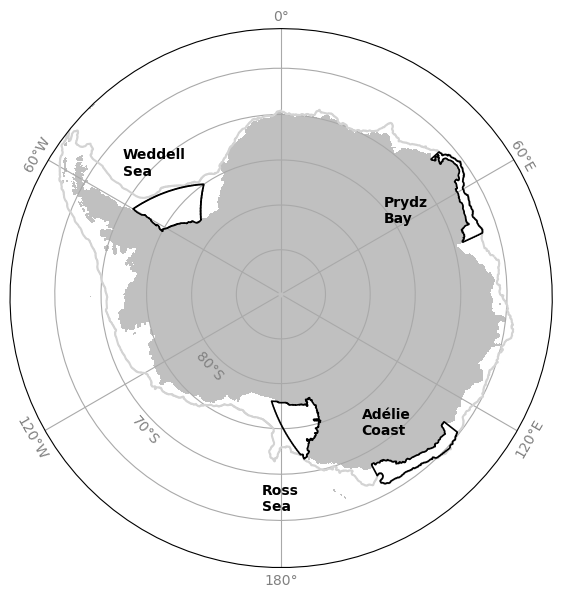

In [40]:
fig = plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=.3)
proj = ccrs.PlateCarree()

ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], proj)
ax.set_boundary(circle, transform=ax.transAxes)

# Land mask
ax.contourf(land_mask.xh.values,
            np.concatenate(([-90], land_mask.yh[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2)

# Gridlines
gl = ax.gridlines(draw_labels=False, color='darkgray', zorder=3)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 60))

label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5]
for i, position in enumerate([0, 180, 60, -120, 120, -60]):
    ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            ha='center', va='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax.text(-135, -j+1.3, label, rotation=-48, ha='center',
            va='center', color='gray', fontsize=10,
            transform=proj)

# Formation region contours
plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Weddell').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)

plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Ross').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)


plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Prydz').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)


plt.contour(mask_DSW.xh, mask_DSW.yh, mask_DSW.sel(area='Adelie').values,
    levels=[0.5], colors='k', linewidths=1.2, transform=proj, zorder=5)


# Shelf contour
plt.contour(shelf_mask.xh, shelf_mask.yh, shelf_mask.values,
            levels=[0, 1], colors='lightgray', linewidth=.7,
            transform=proj)

plt.text(-53, -68, 'Weddell\nSea', fontweight='bold', transform=proj)
plt.text(55, -76, 'Prydz\nBay', fontweight='bold', transform=proj)
plt.text(150, -72, 'Adélie\nCoast', fontweight='bold', transform=proj)
plt.text(-175, -66, 'Ross\nSea', fontweight='bold', transform=proj)


plt.show()
